В данной задаче нам представлены данные в которых ключевое поле — это то, просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет. 

Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix


from datetime import datetime

file_path = 'MFOcredit.csv'

In [2]:
df = pd.read_csv(file_path, encoding='cp1251', sep=';')

In [3]:
df.head()

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,4,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,5,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


In [4]:
df = df.drop(['id'], axis = 1)

In [5]:
df.head()

,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


In [6]:
# преобразовали наши столбцы времени в формат даты
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'])

Из наших полей date_start и date_end получим год, квартал, месяц и день. А так же посчитаем разницу в днях между датой начала и ожидаемой датой окончания.

In [7]:
df.insert(0, 'start_year', df['date_start'].dt.year)
df.insert(1, 'start_quart', df['date_start'].dt.quarter)
df.insert(2, 'start_month', (df['date_start']).dt.month)
df.insert(3, 'start_day', (df['date_start']).dt.day)

df.insert(4, 'end_year', df['date_end'].dt.year)
df.insert(5, 'end_quart', df['date_end'].dt.quarter)
df.insert(6, 'end_month', df['date_end'].dt.month)
df.insert(7, 'end_day', (df['date_start']).dt.day)

In [8]:
df.insert(8, 'date_diff', (df['date_end'] - df['date_start']).dt.days)

In [9]:
df = df.drop(['date_start', 'date_end'], axis = 1)

In [10]:
df.head()

,start_year,start_quart,start_month,start_day,end_year,end_quart,end_month,end_day,date_diff,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,2013,1,1,3,2013,1,1,3,9,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2013,1,1,3,2013,1,1,3,14,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,2013,1,1,3,2013,1,1,3,14,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,2013,1,1,3,2013,1,1,3,14,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,2013,1,1,3,2013,1,1,3,14,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


Сделаем выборку с помощью sql

In [11]:
con = sqlite3.connect('MFOcredit')

In [12]:
df.to_sql('MFOcredit',con, index=False, if_exists='replace')

35212

In [13]:
def select(sql):
  return pd.read_sql(sql,con)

In [14]:
sql = '''select * from MFOcredit as t
where t.gender == 'Женский' and (t.age > 25 and t.age <60)
'''

In [15]:
select(sql)

,start_year,start_quart,start_month,start_day,end_year,end_quart,end_month,end_day,date_diff,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,2013,1,1,3,2013,1,1,3,14,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
1,2013,1,1,3,2013,1,1,3,14,Женский,29,Нет,Собственное,Разведен,Да,Пропуск поля,Кемеровская область север,Нет,Да,Нет
2,2013,1,1,3,2013,1,1,3,14,Женский,27,Пропуск поля,Пропуск поля,Пропуск поля,Да,Пропуск поля,Кемеровская область юг,Да,Нет,Нет
3,2013,1,1,3,2013,1,1,3,14,Женский,39,Пропуск поля,Собственное,Холост,Да,Пропуск поля,Кемеровская область юг,Нет,Да,Нет
4,2013,1,1,3,2013,1,1,3,14,Женский,51,Пропуск поля,Муниципальное,Вдова/вдовец,Да,Пропуск поля,Кемеровская область север,Да,Нет,Нет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13417,2014,1,1,3,2014,1,1,3,14,Женский,27,Нет,Собственное,Холост,Да,Официальное,Кемеровская область юг,Да,Нет,Нет
13418,2014,1,1,3,2014,1,1,3,14,Женский,33,Пропуск поля,Пропуск поля,Пропуск поля,Да,Пропуск поля,Кемеровская область юг,Нет,Да,Нет
13419,2014,1,1,3,2014,1,1,3,14,Женский,46,Нет,Долевая собственность,Гражданский брак/женат/замужем,Да,Официальное,Алтайский край,Нет,Нет,Нет
13420,2014,1,1,3,2014,1,1,3,14,Женский,57,Нет,Собственное,Разведен,Да,Пропуск поля,Алтайский край,Да,Нет,Нет


In [16]:
con.close()

Закодируем признаки с использованием OneHotEncoder

In [17]:
oh = OneHotEncoder()

In [18]:
coder1 = oh.fit_transform(df[['gender']])
coder2 = oh.fit_transform(df[['auto']])
coder3 = oh.fit_transform(df[['housing']])
coder4 = oh.fit_transform(df[['marstatus']])
coder5 = oh.fit_transform(df[['regclient']])
coder6 = oh.fit_transform(df[['jobtype']])
coder7 = oh.fit_transform(df[['region']])
coder8 = oh.fit_transform(df[['credits']])
coder9 = oh.fit_transform(df[['children']])

In [19]:
dff1 = pd.DataFrame(coder1.toarray(), index = df.index, columns = ['female','male'])
dff2 = pd.DataFrame(coder2.toarray(), index = df.index, columns = ['есть машины','нет машины', 'NA авто'])
dff3 = pd.DataFrame(coder3.toarray(), index = df.index, columns = ['Арендуемое', 'Долевая собственность', 'Живут с родителями', 'Муниципальное', 'Пропуск поля', 'Собственное'])
dff4 = pd.DataFrame(coder4.toarray(), index = df.index, columns = ['Вдова/вдовец', 'Гражданский брак/женат/замужем', 'NA СП', 'Разведен', 'Холост'])
dff5 = pd.DataFrame(coder5.toarray(), index = df.index, columns = ['Постоянный клиент','Не постоянный клиент'])
dff6 = pd.DataFrame(coder6.toarray(), index = df.index, columns = ['Нефициальное', 'Официальное', 'NA работа'])
dff7 = pd.DataFrame(coder7.toarray(), index = df.index, columns = ['Алтайский край','Кемеровская область север', 'Кемеровская область юг', 'Красноярский край', 'Новосибирская область'])
dff8 = pd.DataFrame(coder8.toarray(), index = df.index, columns = ['есть кредит','нет кредита', 'NA кредит'])
dff9 = pd.DataFrame(coder9.toarray(), index = df.index, columns = ['есть дети','нет детей', 'NA дети'])

In [20]:
df = pd.concat([df, dff1], axis = 1)
df = pd.concat([df, dff2], axis = 1)
df = pd.concat([df, dff3], axis = 1)
df = pd.concat([df, dff4], axis = 1)
df = pd.concat([df, dff5], axis = 1)
df = pd.concat([df, dff6], axis = 1)
df = pd.concat([df, dff7], axis = 1)
df = pd.concat([df, dff8], axis = 1)
df = pd.concat([df, dff9], axis = 1)

In [21]:
df.head()

,start_year,start_quart,start_month,start_day,end_year,end_quart,end_month,end_day,date_diff,gender,...,Кемеровская область север,Кемеровская область юг,Красноярский край,Новосибирская область,есть кредит,нет кредита,NA кредит,есть дети,нет детей,NA дети
0,2013,1,1,3,2013,1,1,3,9,Мужской,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2013,1,1,3,2013,1,1,3,14,Мужской,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2013,1,1,3,2013,1,1,3,14,Мужской,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2013,1,1,3,2013,1,1,3,14,Женский,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2013,1,1,3,2013,1,1,3,14,Мужской,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [22]:
df = df.drop(['gender', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype', 'credits', 'children','region'], axis = 1)

In [23]:
df.head()

,start_year,start_quart,start_month,start_day,end_year,end_quart,end_month,end_day,date_diff,age,...,Кемеровская область север,Кемеровская область юг,Красноярский край,Новосибирская область,есть кредит,нет кредита,NA кредит,есть дети,нет детей,NA дети
0,2013,1,1,3,2013,1,1,3,9,44,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2013,1,1,3,2013,1,1,3,14,21,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2013,1,1,3,2013,1,1,3,14,25,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2013,1,1,3,2013,1,1,3,14,47,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2013,1,1,3,2013,1,1,3,14,22,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [24]:
df['delinq60plus'] = df['delinq60plus'].replace({'Да': '1', 'Нет': '0'})

In [25]:
df.head()

,start_year,start_quart,start_month,start_day,end_year,end_quart,end_month,end_day,date_diff,age,...,Кемеровская область север,Кемеровская область юг,Красноярский край,Новосибирская область,есть кредит,нет кредита,NA кредит,есть дети,нет детей,NA дети
0,2013,1,1,3,2013,1,1,3,9,44,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2013,1,1,3,2013,1,1,3,14,21,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2013,1,1,3,2013,1,1,3,14,25,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2013,1,1,3,2013,1,1,3,14,47,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2013,1,1,3,2013,1,1,3,14,22,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Разделение данных

In [26]:
X = df.drop(['delinq60plus'], axis = 1)

In [27]:
X.head(5)

,start_year,start_quart,start_month,start_day,end_year,end_quart,end_month,end_day,date_diff,age,...,Кемеровская область север,Кемеровская область юг,Красноярский край,Новосибирская область,есть кредит,нет кредита,NA кредит,есть дети,нет детей,NA дети
0,2013,1,1,3,2013,1,1,3,9,44,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2013,1,1,3,2013,1,1,3,14,21,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2013,1,1,3,2013,1,1,3,14,25,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2013,1,1,3,2013,1,1,3,14,47,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2013,1,1,3,2013,1,1,3,14,22,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [28]:
Y = df['delinq60plus']

In [29]:
Y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: delinq60plus, dtype: object

In [30]:
Y = Y.astype(int)

In [31]:
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size = 0.2, random_state = 42)

Обучение с помощью логистической регрессии

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
logreg = LogisticRegression()

In [34]:
logreg.fit(X_train, Y_train)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [35]:
Y_train_pred_logr = logreg.predict(X_train)
Y_test_pred_logr = logreg.predict(X_test)

In [37]:
train_auc_logr = roc_auc_score(Y_train, Y_train_pred_logr)
test_auc_logr = roc_auc_score(Y_test, Y_test_pred_logr)

print("AUC на обучающем множестве:", train_auc_logr)
print("AUC на проверочном множестве:", test_auc_logr)

AUC на обучающем множестве: 0.7179151780569322
AUC на проверочном множестве: 0.724660698655806


In [38]:
cm = confusion_matrix (Y_test, Y_test_pred_logr)
cm

array([[3644,  707],
       [1045, 1647]], dtype=int64)

In [39]:
fpr, tpr, tr = roc_curve(Y_test, Y_test_pred_logr)

Text(0, 0.5, 'True Positive Rate')

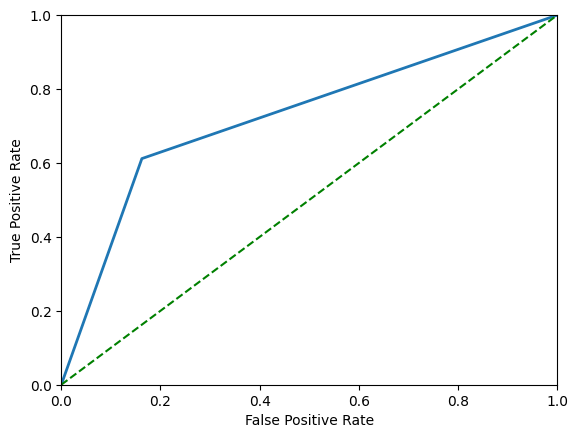

In [40]:
plt.plot(fpr, tpr, linewidth = 2)
plt.plot([0,1], [0,1], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Обучение с помощью случайного леса

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
forestCl = RandomForestClassifier()

In [43]:
forestCl.fit(X_train, Y_train)

RandomForestClassifier()

In [44]:
Y_train_pred_cl = forestCl.predict(X_train)
Y_test_pred_cl = forestCl.predict(X_test)

In [45]:
train_auc = roc_auc_score(Y_train, Y_train_pred_cl)
test_auc = roc_auc_score(Y_test, Y_test_pred_cl)

print("AUC на обучающем множестве:", train_auc)
print("AUC на проверочном множестве:", test_auc)

AUC на обучающем множестве: 0.9995095333628405
AUC на проверочном множестве: 0.7485562916485526


In [46]:
Y_test_pred_cl_new = Y_test_pred_cl.astype(int)

In [47]:
cm = confusion_matrix (Y_test, Y_test_pred_cl_new)
cm

array([[3401,  950],
       [ 766, 1926]], dtype=int64)

In [48]:
fpr, tpr, tr = roc_curve(Y_test, Y_test_pred_cl_new)

Text(0, 0.5, 'True Positive Rate')

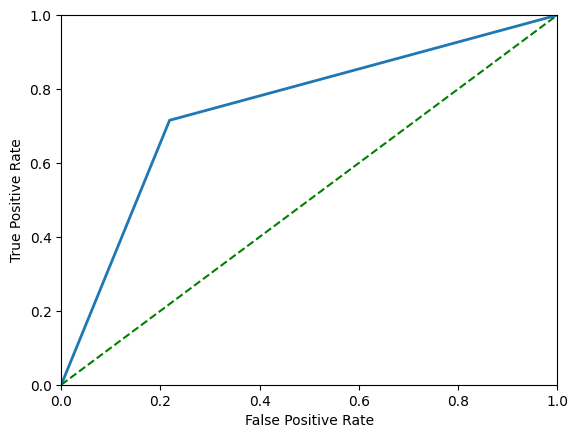

In [49]:
plt.plot(fpr, tpr, linewidth = 2)
plt.plot([0,1], [0,1], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

RandomForestClassifier дает немного лучшие значения, чем логистическая регрессия, но там аблюдается переобучение, т.к.на обучающем множестве AUC = 0,99, а на тестовом значительно меньше